# 图片生成

采用GAN的整体结构如下所示:

![image](png/dcgan.png)

> 图片来在Victor Huang

In [1]:
import sys
sys.path.insert(0, '..')
import os
import torch
import random
from torch import optim
from argparse import Namespace
from solver import DCGANSolver
from model import DCGAN, bce_loss, ls_loss
from dataset import anime_loader
from utils import create_demo

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import utils

In [3]:
# 数据集+选择GAN类型
root = os.path.join(os.path.expanduser('~'), 'data/mlds/faces')
gan = 'DCGAN'

In [4]:
# 参数设置
config = {'batch_size': 256, 'epochs': 300, 'use_cuda': True, 'z_size': 100,
          'save_img_step': 1, 'resume': '', 'verbosity': 1, 'data_dir': root,
          'dis_iter': 1, 'seed': random.randint(1, 10000),
          'gan': gan, 'a': 0, 'b': 1, 'c': 1, 'clip': 0.01, 'valid': False, 'val_step': 200,
          'save_dir': '../pretrained/3_1/' + gan, 'save_freq': 50, 'save_grad': False,
          'visdom': False, 'visdom_iter': True}
config = Namespace(**config)
model = DCGAN(name=config.gan, use_sigmoid=config.gan == 'DCGAN')

In [ ]:
# 训练阶段  --- 可能需要花费几个小时！, 请耐心等待～
# ---友情提示: 你也可以直接使用提供的已训练好的模型, 那么你就别运行这部分了 ---
if config.gan == 'DCGAN':
    optimizer = {'D': optim.Adam(model.D.parameters(), lr=0.0002, betas=(0.5, 0.999)),
                 'G': optim.Adam(model.G.parameters(), lr=0.0002, betas=(0.5, 0.999))}
    criterion = bce_loss
elif config.gan == 'LSGAN':
    config.a, config.b, config.c = 0, 1, 1
    optimizer = {'D': optim.Adam(model.D.parameters(), lr=0.0001, betas=(0.5, 0.999)),
                 'G': optim.Adam(model.G.parameters(), lr=0.0001, betas=(0.5, 0.999))}
    criterion = ls_loss
elif config.gan == 'WGAN':
    config.dis_iter, config.clip = 5, 0.01
    optimizer = {'D': optim.RMSprop(model.D.parameters(), lr=0.00005),
                 'G': optim.RMSprop(model.G.parameters(), lr=0.00005)}
    criterion = None
elif config.gan == 'WGAN-GP':
    config.dis_iter, config.penalty = 5, 10
    optimizer = {'D': optim.Adam(model.D.parameters(), lr=0.0001, betas=(0.5, 0.999)),
                 'G': optim.Adam(model.G.parameters(), lr=0.0001, betas=(0.5, 0.999))}
    criterion = None

train_loader = anime_loader(root, config.batch_size)
solver = DCGANSolver(model, optimizer, criterion, [], train_loader, None, config)
solver.train()

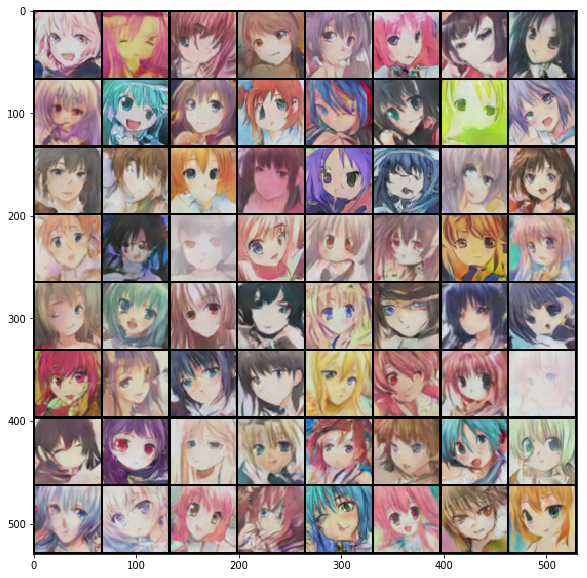

In [5]:
# 可视化
# ---导入训练好的模型---
checkpoints = torch.load('{}/{}_epoch{}.pth.tar'.format(config.save_dir, gan, config.epochs))
model.load_state_dict(checkpoints['state_dict'])
z = torch.randn(64, 100, 1, 1)
img = create_demo(model.G, z, use_cuda=True)
img = utils.make_grid(img.data, normalize=True)
img = img.cpu().numpy().transpose((1, 2, 0))
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

### 结果分析

1. 整体而言，生成的图片"能看"
2. 但在某些图片还是会出现一些"不那么合理的情况"